In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from regression_functions.predictor import Predictor
from scipy import interpolate


In [3]:
df = pd.read_csv('2122_plant_sum_week.csv')
df.drop('Unnamed: 33', axis=1, inplace=True)
df.drop('day', axis=1, inplace=True)
df = df[['dp', 'img_flower_cluster']].sort_values('dp')
df


,dp,img_flower_cluster
14,8766.18330,1.763158
18,10580.75609,1.909091
6,10735.65505,1.897436
19,11289.58914,2.368421
2,12071.43101,1.925000
13,12606.10403,2.105263
4,12809.01409,2.525000
1,12927.53717,2.050000
16,13129.28098,1.500000
15,13843.59549,2.037037


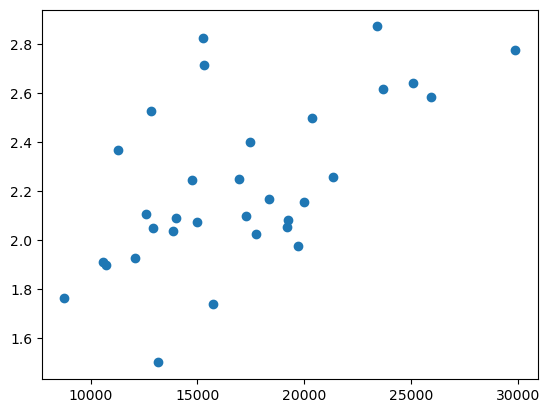

In [4]:
plt.scatter(df['dp'], df['img_flower_cluster'])
plt.show()


In [5]:


class BayesianLinearRegression(Predictor):
    def __init__(self):
        self.m_n = None
        self.S_n = None
        self.sigma = None

    def train(self, train_x, train_y, sigma, m0, s0):
        bias = np.ones((train_x.shape[0], 1))
        X = np.concatenate((train_x, bias), axis=1)
        inv_s0 = np.linalg.inv(s0)
        self.S_n = np.linalg.inv(inv_s0 + (1/(sigma**2))*X.T.dot(X))
        self.sigma = sigma
        self.m_n = self.S_n.dot(inv_s0.dot(
            m0) + (1/(sigma**2))*X.T.dot(train_y))

    def predict(self, test_x):
        bias = np.ones((test_x.shape[0], 1))
        X = np.concatenate((test_x, bias), axis=1)
        mu = X.dot(self.m_n).flatten()
        var = np.array(
            list(map(lambda x: x.dot(self.S_n).dot(x.T) + self.sigma**2, X)))
        # print(var)
        return np.random.normal(mu, var), mu, var


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Linear Regression Bayesian:  
train: 0.00042510032653808594 seconds.
predict: 0.0009570121765136719 seconds.


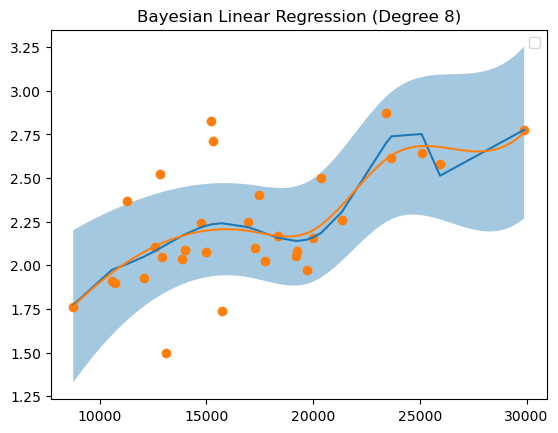

In [20]:
from regression_functions.metrics_tracker import MetricsTracker

# np.random.seed(5)
metrics_tracker = MetricsTracker()

n_samples = 32
degree_x = 8
initial_x = df['dp'].to_numpy().reshape((-1, 1))
y = df['img_flower_cluster'].to_numpy().reshape((-1, 1))
x = initial_x

for i in range(2, degree_x + 1):
    x = np.concatenate((x, pow(initial_x, i)), axis=1)

print("Test Linear Regression Bayesian:  ")
bayesianLinearRegression = BayesianLinearRegression()
metrics_tracker.profile(bayesianLinearRegression.train, x, y, 0.5,
                        np.ones(degree_x + 1).reshape((degree_x+1, 1)), np.eye(degree_x + 1))
test_y_linear_bayesian, mu, var = metrics_tracker.profile(
    bayesianLinearRegression.predict, x)

result_x = x[:,0]
result_y = mu

tck, u = interpolate.splprep([result_x, result_y], s=0.07)
splined_x, splined_y= interpolate.splev(np.linspace(0, 1, 100), tck, der=0)

tck, u = interpolate.splprep([result_x, var], s=0.07)
splined_x, splined_var= interpolate.splev(np.linspace(0, 1, 100), tck, der=0)


plt.plot(result_x, result_y)
plt.plot(splined_x,splined_y)
plt.fill_between(splined_x,  splined_y - 1*splined_var,
                 splined_y + 1*splined_var, alpha=0.4)
plt.scatter(x[:, 0], y)
plt.legend(loc='best')
plt.title(f'Bayesian Linear Regression (Degree {degree_x})')
plt.show()
